In [94]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn

import sklearn
import sklearn.model_selection

rng = np.random.default_rng()

In [95]:
class KinDataset(Dataset):
    def __init__(self, base_folder):
        self.labels = pd.read_csv(base_folder + "/labels.csv", names = ["path", "N"])
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_matrix = pd.read_csv(self.base_folder + "/" + self.labels.iloc[idx, 0], header = 0)
        input_tensor = torch.from_numpy(input_matrix.to_numpy().flatten()).float()
        label = torch.tensor(self.labels.iloc[idx, 1]).float()
        return input_tensor, label
    
kin_dataset = KinDataset("flat_maps_data")

In [96]:
sibs_i = np.arange(0, len(kin_dataset[0][0].numpy()), 3)
hs_i = np.arange(1, len(kin_dataset[0][0].numpy()), 3)
print(kin_dataset[0])

(tensor([0.0000, 0.0000, 5.0000,  ..., 2.5470, 2.4326, 5.1478]), tensor(292.))


In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [99]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        return x

In [100]:
len(kin_dataset[0][0])

3480

In [101]:
n_total = len(kin_dataset)
n_train = round(n_total*0.8)
print(n_train)
n_test = n_total-n_train
print(n_test)

1600
400


In [102]:
train_kin, test_kin = random_split(kin_dataset, [n_train, n_test], generator=torch.Generator().manual_seed(42))
#train_kin, test_kin = random_split(kin_dataset, [590, 10], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(test_kin))

1600
400


In [103]:
len(kin_dataset[0][0])

3480

In [104]:
input_size = len(kin_dataset[0][0])
output_size = 1
hidden_size = round(input_size/2)

model = Model(input_size, hidden_size, output_size)

learning_rate = 0.001

loss_fn = nn.HuberLoss(reduction='mean')

learning_rate = 0.001
num_epochs = 200
log_epochs = 1

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
#for x_batch, y_batch in test_kin_dl:
    #print(x_batch.size())
    #print(y_batch.size())
    #pred = model(x_batch)[:,0]
    #print(pred)
    #loss = loss_fn(pred, y_batch)
    #print(loss)
    

In [105]:
for epoch in range(num_epochs):
    for x_batch, y_batch in train_kin_dl:
        # 1. Generate predictions
        pred = model(x_batch)[:,0]

        # 2. Calculate loss
        loss = loss_fn(pred, y_batch)

        # 3. Compute gradients
        loss.backward()

        # 4. Update parameters using gradients
        optimizer.step()

        # 5. Reset the gradients to zero
        optimizer.zero_grad()
        
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 154.9869
Epoch 1  Loss 140.4544
Epoch 2  Loss 146.1306
Epoch 3  Loss 120.5878
Epoch 4  Loss 142.2231
Epoch 5  Loss 131.9130
Epoch 6  Loss 130.4260
Epoch 7  Loss 130.4949
Epoch 8  Loss 142.9713
Epoch 9  Loss 138.5595
Epoch 10  Loss 133.0887
Epoch 11  Loss 129.5064
Epoch 12  Loss 128.8320
Epoch 13  Loss 131.1015
Epoch 14  Loss 148.2810
Epoch 15  Loss 118.1572
Epoch 16  Loss 154.0103
Epoch 17  Loss 125.5410
Epoch 18  Loss 117.9167
Epoch 19  Loss 119.6866
Epoch 20  Loss 108.4408
Epoch 21  Loss 141.9755
Epoch 22  Loss 131.7346
Epoch 23  Loss 144.6318
Epoch 24  Loss 132.9203
Epoch 25  Loss 145.9563
Epoch 26  Loss 134.1872
Epoch 27  Loss 119.6552
Epoch 28  Loss 141.9584
Epoch 29  Loss 133.1529
Epoch 30  Loss 133.1203
Epoch 31  Loss 117.7678
Epoch 32  Loss 131.0081
Epoch 33  Loss 146.2574
Epoch 34  Loss 126.4366
Epoch 35  Loss 122.2701
Epoch 36  Loss 130.3993
Epoch 37  Loss 123.6563
Epoch 38  Loss 114.2097
Epoch 39  Loss 114.6310
Epoch 40  Loss 112.9993
Epoch 41  Loss 126.3272
Ep

In [106]:
test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(test_kin):
        test_truth[i] = model(test_input)[0].numpy()
        test_pred[i] = test_output.numpy()
        #test_truth[i] = test_output[0].numpy()
        #test_pred[i] = model(test_input)[0, 0].numpy()

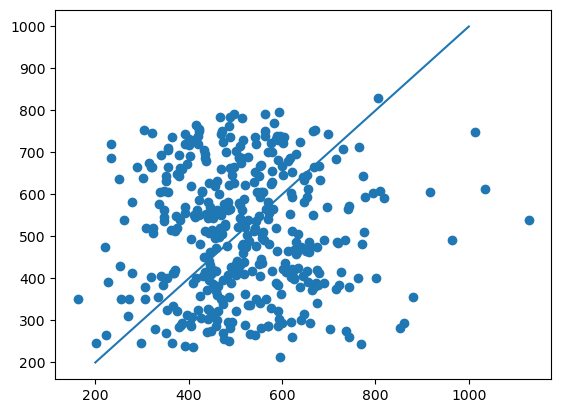

In [108]:
plt.scatter(test_truth, test_pred)
plt.plot([200, 1000], [200, 1000])